In [1]:
# Import needed packages for analysis
import os

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nibabel as nib
from sklearn.preprocessing import StandardScaler

import cfl.util.brain_util as BU
import cfl.util.brain_vis as BV
from cfl.util import fear_mice_functions as fm
from cfl.util.fear_mice_functions import get_global_values


mri_dir, mri_dims, affine, dir_labels = get_global_values()

# load the non-linear mask template
nl_mask_path = os.path.join('PTSD_Data_Share/templates\MuseTemplate_nonlinear_mask.nii')
nl_mask = BU.load_brain(nl_mask_path, ori='RPS')
nolin_mask_vec = BU.flatten(nl_mask)

In [2]:
# load response data 
Y = pd.read_pickle('Y.pkl')

# # load all the images 
X = np.load('smooth_X_paper_sigma.npy')


In [3]:
folder_path = os.path.join('npy_files', 'smooth')

# # uncomment one of the following
data_id = 'smooth_X_'
# data_id = 'smooth_X_WT_'

In [7]:
def threeD_index_to_flat(i, dim): 
    return i[0] * (dim[1]*dim[2]) + i[1] * dim[2] + i[2]

## Load Ridge Regression Results

In [47]:
ridge_coef = np.load(os.path.join(folder_path, data_id + "ridge_reg_coefs.npy"))
ridge_alpha = np.load(os.path.join(folder_path, data_id + "ridge_reg_alpha.npy"))

# Thresholding regions with Ridge Regression 

In [15]:
def plot_cluster_bar(df): 
    xs = df["Cluster Index"].to_numpy()
    ys = df.Voxels.to_numpy()

    sort_inds = np.flip(np.argsort(xs))
    sorted_xs = xs.ravel()[sort_inds.reshape(xs.shape)]
    sorted_ys = ys.ravel()[sort_inds.reshape(ys.shape)]

    plt.figure(figsize=(19, 4))
    plt.bar(sorted_xs.astype(int).astype(str), height=sorted_ys)
    plt.suptitle("Size of each 'significant' cluster in the ridge regression Alphas")
    plt.xticks([])
    plt.ylabel("Number of Voxels in cluster")
    plt.xlabel("Index")
    plt.show()


### Create Binary Mask on Alphas 

In [16]:
# ridge_alpha_mask = boolean array of 0s where the lambda has 'whited out' the slope (drawn it towards 0) and 1 if it isn't 
high_lambda = np.percentile(ridge_alpha, 99)

print(high_lambda)
ridge_alpha_mask = np.where(np.around(ridge_alpha, 2) >= high_lambda, 0, 1)

# save this array as a nii and run fsl cluster on it
fm.save_as_nifti(ridge_alpha_mask, data_id + "ridge_alpha_mask.nii", mri_dims, affine)

4.849999999999999


### Identify Clusters for Binary Alphas Mask (happens outside this notebook)

In [49]:
# to generate the clusters:

# # fix the 'can't locate shared library' error by doing 
# # https://stackoverflow.com/questions/480764/linux-error-while-loading-shared-libraries-cannot-open-shared-object-file-no-s 
# # echo $LD_LIBRARY_PATH
# # LD_LIBRARY_PATH=/usr/local/fsl/fslpython/lib; export LD_LIBRARY_PATH

# # navigate to the folder where the mask is 
# # run the following command in a terminal (on a system where you have FSL installed )
# # clustering command: 
# cluster --in=<data_id>ridge_alpha_mask.nii --thresh=1 > clusters_<data_ID>ridge_alphas.txt


In [21]:
# load csv file with cluster data in 
ridge_clusters = pd.read_csv("clusters_" + data_id +"ridge_alphas.txt", sep="\t")

ridge_clusters

,Cluster Index,Voxels,MAX,MAX X (vox),MAX Y (vox),MAX Z (vox),COG X (vox),COG Y (vox),COG Z (vox)
1,276,2871,1,70,106,15,88.3,107.0,33.6
2,275,2602,1,29,145,38,59.0,135.0,51.5
3,274,2517,1,77,80,43,68.4,72.6,57.8
4,273,1485,1,47,110,45,50.6,109.0,51.2
5,272,1054,1,50,155,15,52.2,150.0,21.5
...,...,...,...,...,...,...,...,...,...
272,5,1,1,54,167,27,54.0,167.0,27.0
273,4,1,1,45,75,47,45.0,75.0,47.0
274,3,1,1,35,136,28,35.0,136.0,28.0
275,2,1,1,98,96,46,98.0,96.0,46.0


In [ ]:
# remove the cluster for all the empty space outside the brain (big)
ridge_clusters = ridge_clusters[ridge_clusters.Voxels < 10000]

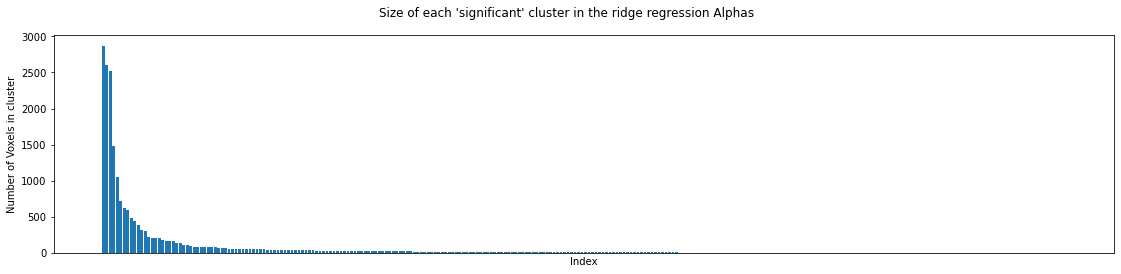

In [22]:
# graph all the clusters to see their sizes 
plot_cluster_bar(ridge_clusters)

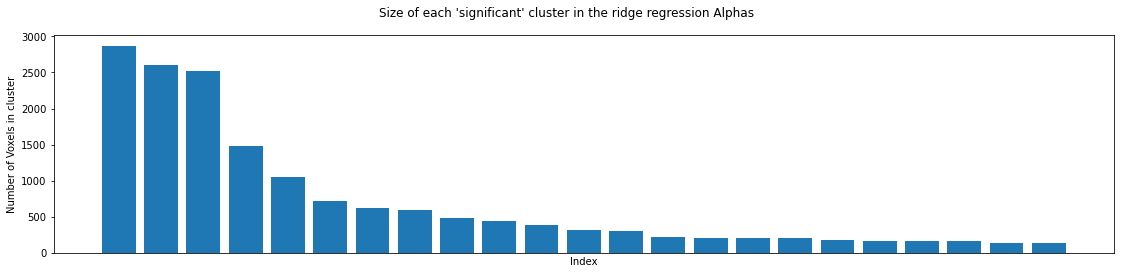

Number of remaining clusters: 23


In [23]:
# remove all clusters with fewer than <threshold> voxels
# 128 is the voxel threshold used by the paper  
threshold = 128 
trimmed_ridge_clusters = ridge_clusters[ridge_clusters.Voxels > threshold]

plot_cluster_bar(trimmed_ridge_clusters)

# how many clusters left? 
print("Number of remaining clusters:", trimmed_ridge_clusters.Voxels.count())

In [57]:
# where are the biggest few clusters? 
# three biggest clusters
trimmed_ridge_clusters[:3]

,Cluster Index,Voxels,MAX,MAX X (vox),MAX Y (vox),MAX Z (vox),COG X (vox),COG Y (vox),COG Z (vox)
1,276,2871,1,70,106,15,88.3,107.0,33.6
2,275,2602,1,29,145,38,59.0,135.0,51.5
3,274,2517,1,77,80,43,68.4,72.6,57.8


### Create a brain where each cluster is colored a different color

In [24]:
# # install skimage (uncomment if skimage is not already installed)
# import sys
# !conda install --yes --prefix {sys.prefix} scikit-image

from skimage.segmentation import flood

# create mask for all clusters > 128 voxels
def cluster_mask(cluster_df, alphas_mask): 
    '''creates an array where each cluster is labeled with a different int (non-cluster space is 0)
    alphas_mask should be 3D'''
    clusters_mask = np.zeros(alphas_mask.shape)

    for i, row in cluster_df.iterrows(): 
        location_of_cluster = (int(row["MAX X (vox)"]), int(row["MAX Y (vox)"]), int(row["MAX Z (vox)"]))

        mask = flood(unflat_alphas_mask, location_of_cluster) 
        clusters_mask[mask] = (i) 
    return clusters_mask


In [ ]:
# get rid of any nans
unflat_alphas_mask = BU.unflatten(ridge_alpha_mask, mri_dims)
where_are_NaNs = np.isnan(unflat_alphas_mask)
unflat_alphas_mask[where_are_NaNs] = 0

In [27]:
# create mask for all clusters 
cluster_masked = cluster_mask(ridge_clusters, unflat_alphas_mask)
fm.save_as_nifti(cluster_masked, data_id + "all_ridge_clusters.nii",mri_dims, affine)

# # create mask for all clusters >128 
# cluster_masked = cluster_mask(trimmed_ridge_clusters, unflat_alphas_mask)
# fm.save_as_nifti(cluster_masked, data_id + "large_ridge_clusters.nii",mri_dims, affine)

In [28]:
print(np.unique(cluster_masked))

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23.]


### Compare overlap between clusters and atlas regions

In [59]:
# load atlas in RPS orientation 
atlas = BU.load_brain(os.path.join('PTSD_Data_Share', "PTSD_InVivoAtlas_labels.nii"), ori='RPS')

In [60]:
def percent_overlap(mask1, mask2): 
    '''create a array that shows the percent overlap for each region in mask1 with each region in mask2'''
    # create a new array with the regions in mask2 as the column titles and the regions in mask1 as the rows
    mask1_regions = np.unique(mask1)
    mask2_regions = np.unique(mask2)

    return_array = np.zeros((len(mask1_regions), len(mask2_regions)))

    assert mask1.shape==mask2.shape, "make sure both arrays are same shape"
    # for each voxel in mask1: 
    it = np.nditer(mask1, flags=['multi_index'])
    for voxel in it:
        mask1_index = np.where(mask1_regions==voxel)[0][0]

        # mask2_index should be..... for this 
        mask2_voxel = mask2[it.multi_index]
        mask2_index = np.where(mask2_regions==mask2_voxel)[0][0]

        # add 1 to the array for the appropriate voxel in mask2 
        return_array[mask1_index][mask2_index] += 1

    # divide each entry by the number of total voxels for that region in mask1 
    for i, row in enumerate(return_array): 
        voxels_in_this_region = np.sum(mask1==mask1_regions[i])
        return_array[i] = np.divide(row, voxels_in_this_region)

    return {"rows": mask1_regions, "cols": mask2_regions, "values": return_array}

In [ ]:
# load atlas to name spreadsheet
atlas_names_df = pd.read_excel(os.path.join('C:/Users/jkahn/Documents/Schmidt/cfl/cfl_examples/fear_mice/PTSD_Data_Share/PTSD_InVivoAtlas_labels_grouping_mod.xlsx'))

# create a dictionary between the region numbers and names 
regions_to_abbrs = atlas_names_df.groupby('Original_Invivo_Index')['Abbr'].apply(list).to_dict()
for key in regions_to_abbrs: 
    regions_to_abbrs[key] = regions_to_abbrs[key][0]

def num_to_abbr(region_num, dict):
    if region_num in dict: 
        return dict[region_num]
    else: 
        return str(int(region_num))


In [61]:
# then do 'best reciprocal hit' method 
cluster_to_atlas = percent_overlap(cluster_masked, atlas)

atlas_to_cluster = percent_overlap(atlas, cluster_masked)

In [63]:

cluster_regions = cluster_to_atlas['rows']
atlas_regions = cluster_to_atlas['cols']
overlap_array = cluster_to_atlas['values']
# find the non-zero values and print them 

threshold = 25

print("Printing only clusters that are located at least", str(threshold)+"% within a single atlas region")
for i, row in enumerate(overlap_array): 
    if i != 0: #skip the 0th cluster (not a cluster)
        for j, entry in enumerate(row): # iterate over the clusters
            if np.around(overlap_array[i][j]*100) > 25:  
                print('Cluster number:', cluster_regions[i], 'size:', np.sum(cluster_masked==cluster_regions[i]), "voxels")

                region_name = num_to_abbr(atlas_regions[j], regions_to_abbrs)
                print('\t Parcel:', region_name, 'size:', np.sum(atlas==atlas_regions[j]), "voxels")
                print("\t percent overlap from cluster to region: ", np.around(overlap_array[i][j]*100, 4)) 
                print('\t percent overlap from region to cluster:', np.around(atlas_to_cluster['values'][j][i], 4))


Printing only clusters that are located at least 25% within a single atlas region
Cluster number: 2.0 size: 242 voxels
	 Parcel: VL size: 7873 voxels
	 percent overlap from cluster to region:  40.0826
	 percent overlap from region to cluster: 0.0123
Cluster number: 3.0 size: 218 voxels
	 Parcel: CB size: 51799 voxels
	 percent overlap from cluster to region:  99.0826
	 percent overlap from region to cluster: 0.0042
Cluster number: 4.0 size: 178 voxels
	 Parcel: P size: 5004 voxels
	 percent overlap from cluster to region:  65.1685
	 percent overlap from region to cluster: 0.0232
Cluster number: 4.0 size: 178 voxels
	 Parcel: PRN size: 5166 voxels
	 percent overlap from cluster to region:  28.0899
	 percent overlap from region to cluster: 0.0097
Cluster number: 5.0 size: 173 voxels
	 Parcel: MedOblog size: 23892 voxels
	 percent overlap from cluster to region:  93.6416
	 percent overlap from region to cluster: 0.0068
